# Deep Learning Applications: Laboratory 1




### Install dependencies

`pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118`  
`pip install matplotlib`  
`pip install scikit-learn`  
`pip install tqdm`  
`pip install jupyterlab`  
`pip install ipython`  
`pip install wandb`  

## Exercise 1.1: A baseline MLP
In this exercise I implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST.
Then I evaluate the model in terms of loss and accuracy on validation and test set.
I use [Weights and Biases](https://wandb.ai/site) to monitor performance during the training process.

#### Import Dependencies

In [1]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
import wandb
import math
import os
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

#### Define Training Pipeline and utility functions
These are the functions used for training and test processes.
After the training loop the best model (based on validation accuracy) is saved in `/trained_models` directory.

In [3]:
def train_epoch(model, dataloader, criterion, optimizer, epoch='Unknown', device='cpu', fully_conv=False):
    model.train()
    losses = []
    for (inputs, labels) in tqdm(dataloader, desc=f'Training epoch {epoch}', leave=True):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        if fully_conv:
            _, _, a, b = outputs.shape
            gts = labels.unsqueeze(-1).unsqueeze(-1).repeat(1,a,b)
            loss = criterion(outputs, gts)
        else:
          loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    avg_loss = np.mean(losses)
    return avg_loss


def evaluate_model(model, dataloader, criterion, device='cpu'):
    model.eval()
    losses = []
    predictions = []
    gts = []
    with torch.no_grad():
        for (inputs, labels) in tqdm(dataloader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)
            gts.append(labels.cpu().numpy())
            predictions.append(preds.detach().cpu().numpy())
            losses.append(loss.item())
    avg_loss = np.mean(losses)
    accuracy = accuracy_score(np.hstack(gts), np.hstack(predictions))
    report = classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3)
    return avg_loss, accuracy, report


def plot_validation_curves(losses_and_accs, fig_path):
    train_losses = [x for (x, _, _) in losses_and_accs]
    val_losses = [x for (_, x, _) in losses_and_accs]
    accs = [x for (_, _, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {round(np.max(accs), 2)} @ epoch {np.argmax(accs)}')
    plt.savefig(fig_path)

In [4]:
def train(model, train_set, criterion, optimizer, batch_size, epochs, model_name, fig_path, device='cpu', fully_conv=False):
    # Init Weights and Biases
    wandb.init(project="dla_lab1")

    # Split train into train and validation.
    train_size = int(0.9 * len(train_set))
    val_size = len(train_set) - train_size
    train_set, val_set = random_split(train_set, [train_size, val_size])

    # Create data loaders.
    dl_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
    print("Training-Set Ready")
    dl_val = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)
    print("Validation-Set Ready")

    wandb.watch(model, log="all")
    model.to(device)
    print("Starting Training...")
    losses_and_accs = []
    max_val_acc = 0
    min_val_loss = math.inf
    early_stop_counter = 0
    best_state_dict = None
    for epoch in range(epochs):
        # Train Epoch
        train_loss = train_epoch(model, dl_train, criterion, optimizer, epoch, device, fully_conv)
        # Evaluate Model
        val_loss, val_acc, _ = evaluate_model(model, dl_val, criterion, device)

        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "val_accuracy": val_acc, "epoch": epoch})
        losses_and_accs.append((train_loss, val_loss, val_acc))

        # Pick best model
        if val_acc > max_val_acc:
            max_val_acc = val_acc
            best_state_dict = model.state_dict()

        #Early Stopping
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            early_stop_counter = 0
        elif val_loss > (min_val_loss + 0.05):
            early_stop_counter += 1
        if early_stop_counter == 5:
            break

    wandb.unwatch()
    plot_validation_curves(losses_and_accs, fig_path)
    torch.save(best_state_dict, os.path.join('./trained_models/', model_name))

In [5]:
def test(model, test_set, criterion, model_name, device='cpu'):
    # Create data loader.
    test_dl = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)

    # Load best model state dict
    print("Loading model...")
    model.load_state_dict(torch.load(os.path.join('./trained_models/', model_name)))
    model.to(device)
    print("Model Loaded")

    _, test_acc, classification_report = evaluate_model(model, test_dl, criterion, device)
    print(f'Test Accuracy: {test_acc}')
    print(classification_report)

#### A basic, parameterized MLP

Here I use the suggested implementation of Mulilayer Perceptron. It sllows to pass in a list inpits, hidden layers and output *widths*.

In [6]:
class MLP(nn.Module):
    def __init__(self, dim=64):
        super().__init__()
        self.fc1 = nn.Linear(28*28, dim)
        self.fc2 = nn.Linear(dim, dim*2)
        self.fc3 = nn.Linear(dim*2, dim*4)
        self.fc4 = nn.Linear(dim*4, dim*8)
        self.fc5 = nn.Linear(dim*8, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return x

#### Data preparation
In this section they are loaded train and test sets of MNIST data.

In [6]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
train_set = MNIST(root='./data', train=True, download=True, transform=transform)
test_set = MNIST(root='./data', train=False, download=True, transform=transform)

#### Define Hyperparameters and Run Training
In this cell they are defined the hyperparameters for network architecture and for the training process.
They can be defined the model name (for saving) and the path for resulting plot.

In [8]:
# Training hyperparameters.
epochs = 20
batch_size = 128
lr = 0.0001

# Instantiate model and optimizer
model_mlp = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

model_name = 'mlp_mnist.pth'
fig_path = 'results/mlp_mnist.png'

# Training loop
train(model_mlp, train_set, criterion, optimizer, batch_size, epochs, model_name, fig_path, device=device)

# Test model on test set
test(model_mlp, test_set, criterion, 'mlp_mnist.pth', device=device)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: thomasdelmoro. Use `wandb login --relogin` to force relogin


Training-Set Ready
Validation-Set Ready
Starting Training...


Training epoch 2:  70%|██████▉   | 294/422 [00:14<00:06, 19.83it/s]


KeyboardInterrupt: 

## Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 2.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

#### Data Preparation

In [ ]:
# These lines solve an SSL issue with the CIFAR10 dataset.
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Standard CIFAR10 transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR10 train and test.
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)

num_classes = 10
input_channels = 3

Files already downloaded and verified
Files already downloaded and verified


#### Architecture

In this section I try to implement the original ResNet18 architecture, leaving a flag indicating the use or not use of skip connections, in order to quantify the differences in performance between the two architectural choices.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, input_channels, dim=64):
        super().__init__()
        self.input_dim = input_dim
        self.input_channels = input_channels
        self.fc1 = nn.Linear(self.input_dim*self.input_dim*self.input_channels, dim*8)
        self.fc2 = nn.Linear(dim*8, dim*4)
        self.fc3 = nn.Linear(dim*4, dim*2)
        self.fc4 = nn.Linear(dim*2, dim)
        self.fc5 = nn.Linear(dim, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return x

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, skip_connection=True):
        super(ResidualBlock, self).__init__()
        self.skip_connection = skip_connection

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = self.block(x)
        if self.skip_connection:
            out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes, channels=3, skip_connection=True):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.num_classes = num_classes
        self.skip_connection = skip_connection

        self.conv = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.layers = nn.Sequential(
            self._make_layer(ResidualBlock, 64, num_blocks[0], stride=1, skip_connection=skip_connection),
            self._make_layer(ResidualBlock, 128, num_blocks[1], stride=2, skip_connection=skip_connection),
            self._make_layer(ResidualBlock, 256, num_blocks[2], stride=2, skip_connection=skip_connection),
            self._make_layer(ResidualBlock, 512, num_blocks[3], stride=2, skip_connection=skip_connection),
        )

        self.pooling = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride, skip_connection=True):
        # [stride, 1, 1, ...] (num_blocks times) ensures that the first block has stride=stride
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, skip_connection=skip_connection))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        conv:    [batch_size, channels, 32, 32] -> [batch_size, 64, 32, 32]
        layer1:  [batch_size, 64, 32, 32] -> [batch_size, 64, 32, 32] (stride=1)
        layer2:  [batch_size, 64, 32, 32] -> [batch_size, 128, 16, 16] (stride=2)
        layer3:  [batch_size, 128, 16, 16] -> [batch_size, 256, 8, 8] (stride=2)
        layer4:  [batch_size, 256, 8, 8] -> [batch_size, 512, 4, 4] (stride=2)
        pooling: [batch_size, 512, 4, 4] -> [batch_size, 512, 1, 1] (avg_pool2d)
        resize:  [batch_size, 512, 1, 1] -> [batch_size, 512]
        fc:      [batch_size, 512] -> [batch_size, num_classes]
        """
        x = self.conv(x)
        x = self.layers(x)
        x = self.pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

#### Define Hyperparameters and Run Training

In [ ]:
# Training hyperparameters.
epochs = 25
batch_size = 64
lr = 0.0001

# Instantiate models and optimizer
criterion = nn.CrossEntropyLoss()

mlp = MLP(32, 3)
optimizer_mlp = torch.optim.SGD(params=mlp.parameters(), lr=lr, momentum=0.9)

convnet = ResNet([2, 2, 2, 2], 10, 3, skip_connection=False)
optimizer_convnet = torch.optim.SGD(params=convnet.parameters(), lr=lr, momentum=0.9)

resnet = ResNet([2, 2, 2, 2], 10, 3, skip_connection=True)
optimizer_resnet = torch.optim.SGD(params=resnet.parameters(), lr=lr, momentum=0.9)


In [39]:
model_name = 'mlp_cifar2.pth'
fig_path = 'results/mlp_cifar2.png'

# Train and test the models
train(mlp, train_set, criterion, optimizer_mlp, batch_size, epochs, model_name, fig_path, device=device)
test(mlp, test_set, criterion, 'mlp_cifar2.pth', device=device)

Training-Set Ready
Validation-Set Ready
Starting Training...


Training epoch 13:  66%|██████▌   | 465/704 [00:09<00:04, 49.50it/s]


KeyboardInterrupt: 

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,███▇▇▇▆▆▅▄▃▂▁
val_accuracy,▁▂▃▄▅▅▄▄▅▅▅▇█
val_loss,███▇▇▇▆▆▅▄▄▂▁
epoch,12
train_loss,2.13537
val_accuracy,0.209
val_loss,2.13533


Training-Set Ready
Validation-Set Ready
Starting Training...


Training epoch 17: 100%|██████████| 704/704 [00:47<00:00, 14.91it/s]


Loading model...
Model Loaded


Test Accuracy: 0.6579
              precision    recall  f1-score   support

           0      0.693     0.703     0.698      1000
           1      0.769     0.837     0.801      1000
           2      0.545     0.537     0.541      1000
           3      0.441     0.543     0.487      1000
           4      0.636     0.511     0.567      1000
           5      0.569     0.504     0.534      1000
           6      0.689     0.752     0.719      1000
           7      0.755     0.607     0.673      1000
           8      0.796     0.777     0.786      1000
           9      0.721     0.808     0.762      1000

    accuracy                          0.658     10000
   macro avg      0.661     0.658     0.657     10000
weighted avg      0.661     0.658     0.657     10000



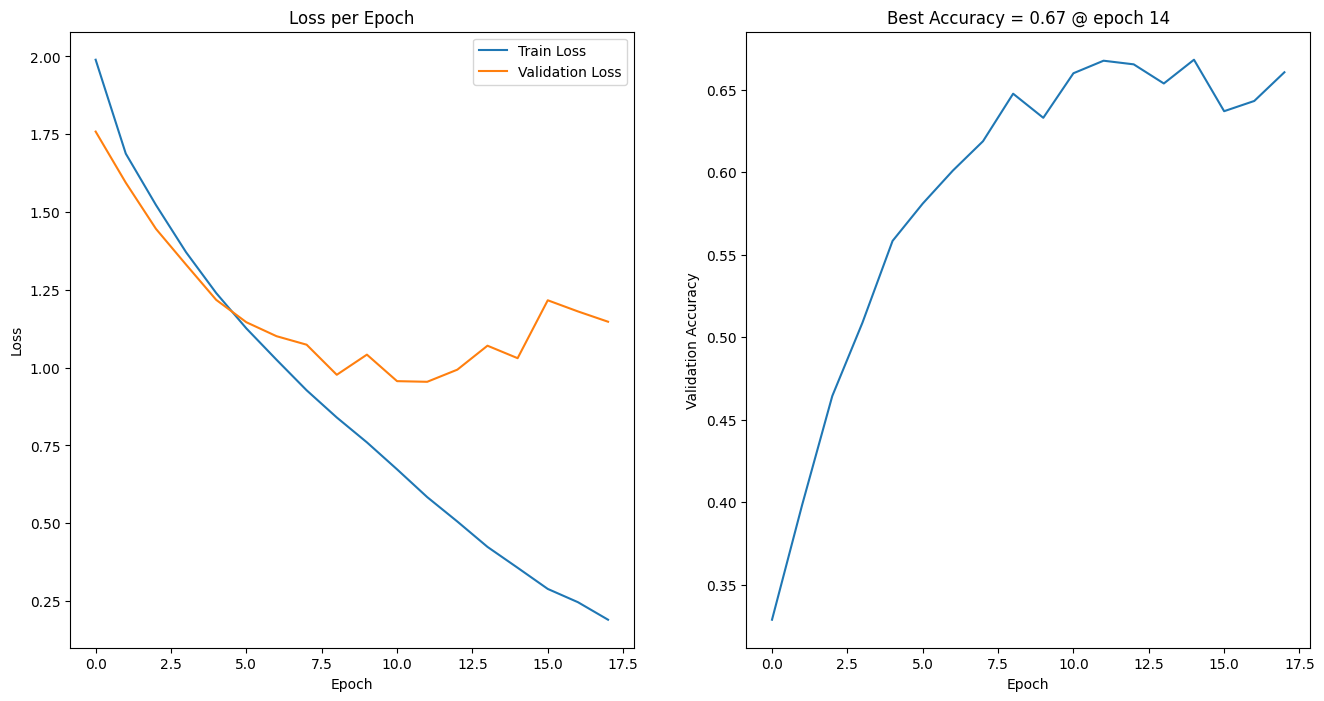

In [41]:
model_name = 'cnn_cifar.pth'
fig_path = 'results/cnn_cifar.png'

# Train and test the models
train(convnet, train_set, criterion, optimizer_convnet, batch_size, epochs, model_name, fig_path, device=device)
test(convnet, test_set, criterion, 'cnn_cifar.pth', device=device)

epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_loss,█▇▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁
val_accuracy,▁▂▄▅▆▆▇▇█▇█████▇▇█
val_loss,█▇▅▄▃▃▂▂▁▂▁▁▁▂▂▃▃▃
epoch,17
train_loss,0.18973
val_accuracy,0.6606
val_loss,1.14749


Training-Set Ready
Validation-Set Ready
Starting Training...


Training epoch 15: 100%|██████████| 704/704 [00:50<00:00, 13.90it/s]


Loading model...
Model Loaded


Test Accuracy: 0.6628
              precision    recall  f1-score   support

           0      0.603     0.770     0.677      1000
           1      0.740     0.823     0.779      1000
           2      0.595     0.504     0.546      1000
           3      0.528     0.422     0.469      1000
           4      0.627     0.590     0.608      1000
           5      0.542     0.590     0.565      1000
           6      0.750     0.750     0.750      1000
           7      0.663     0.733     0.696      1000
           8      0.887     0.654     0.753      1000
           9      0.725     0.792     0.757      1000

    accuracy                          0.663     10000
   macro avg      0.666     0.663     0.660     10000
weighted avg      0.666     0.663     0.660     10000



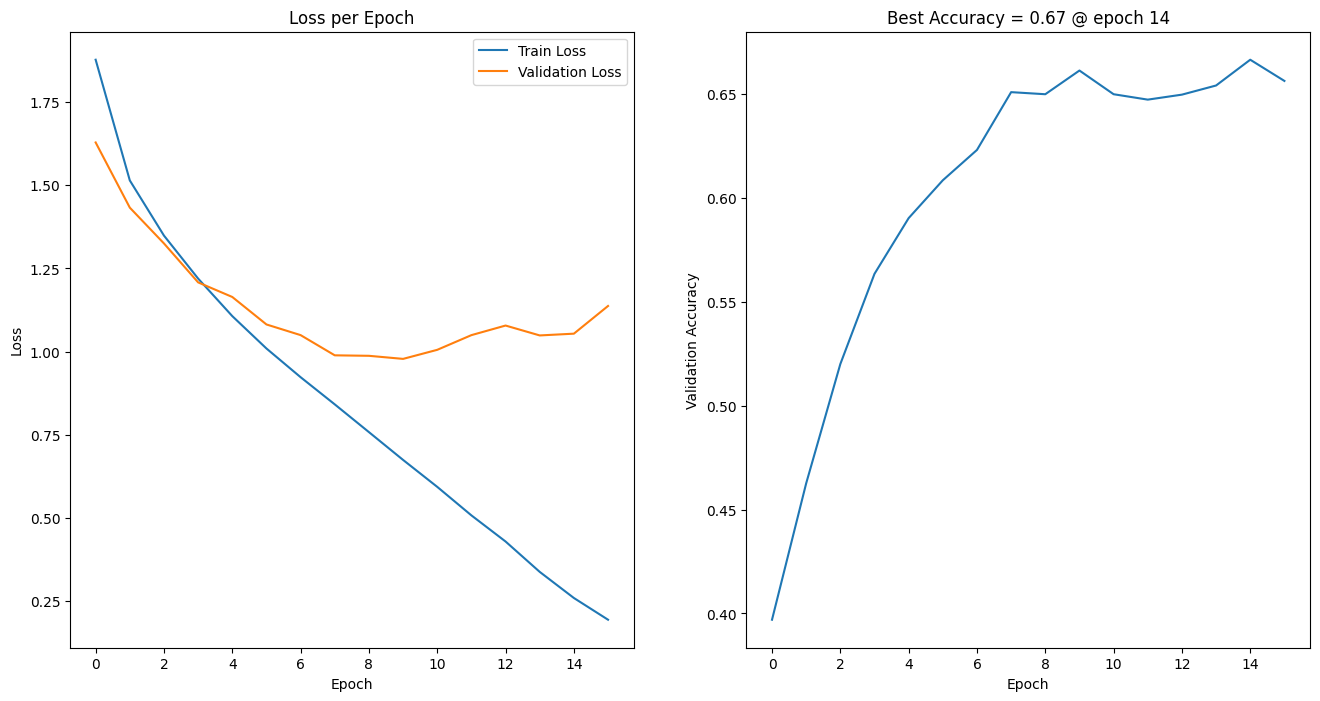

In [42]:
model_name = 'resnet_cifar.pth'
fig_path = 'results/resnet_cifar.png'

# Train and test the models
train(resnet, train_set, criterion, optimizer_resnet, batch_size, epochs, model_name, fig_path, device=device)
test(resnet, test_set, criterion, 'resnet_cifar.pth', device=device)

In [14]:
convnet = ResNet([2, 2, 2, 2], 10, 3, skip_connection=False)
resnet = ResNet([2, 2, 2, 2], 10, 3, skip_connection=True)


test(convnet, test_set, criterion, 'cnn_cifar.pth', device=device)
test(resnet, test_set, criterion, 'resnet_cifar.pth', device=device)

Loading model...
Model Loaded


Test Accuracy: 0.6579
              precision    recall  f1-score   support

           0      0.693     0.703     0.698      1000
           1      0.769     0.837     0.801      1000
           2      0.545     0.537     0.541      1000
           3      0.441     0.543     0.487      1000
           4      0.636     0.511     0.567      1000
           5      0.569     0.504     0.534      1000
           6      0.689     0.752     0.719      1000
           7      0.755     0.607     0.673      1000
           8      0.796     0.777     0.786      1000
           9      0.721     0.808     0.762      1000

    accuracy                          0.658     10000
   macro avg      0.661     0.658     0.657     10000
weighted avg      0.661     0.658     0.657     10000

Loading model...
Model Loaded


Test Accuracy: 0.6628
              precision    recall  f1-score   support

           0      0.603     0.770     0.677      1000
           1      0.740     0.823     0.779      1000
           2      0.595     0.504     0.546      1000
           3      0.528     0.422     0.469      1000
           4      0.627     0.590     0.608      1000
           5      0.542     0.590     0.565      1000
           6      0.750     0.750     0.750      1000
           7      0.663     0.733     0.696      1000
           8      0.887     0.654     0.753      1000
           9      0.725     0.792     0.757      1000

    accuracy                          0.663     10000
   macro avg      0.666     0.663     0.660     10000
weighted avg      0.666     0.663     0.660     10000



-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.1: Explain why Residual Connections are so effective
Use your two models (with and without residual connections) you developed above to study and **quantify** why the residual versions of the networks learn more effectively.

**Hint**: A good starting point might be looking at the gradient magnitudes passing through the networks during backpropagation.

In [ ]:
# Your code here.

### Exercise 2.2: Fully-convolutionalize a network.
Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

In [8]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
train_set = MNIST(root='./data', train=True, download=True, transform=transform)
test_set = MNIST(root='./data', train=False, download=True, transform=transform)

###Architecture

In [9]:
class CNN(nn.Module):
    def __init__(self, input_channels, output_dim = 10):
        super().__init__()
        hidden_dim = 32
        self.conv1 = nn.Conv2d(input_channels, hidden_dim, kernel_size=3, stride = 2, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=3, stride = 2, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=3, stride = 1, padding=1)
        self.conv4 = nn.Conv2d(hidden_dim * 4, hidden_dim * 8, kernel_size=3, stride = 1, padding=1)
        self.classifier = nn.Sequential(
            nn.Linear(12544, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        return self.classifier(x.flatten(1))

In [10]:
class FCN(nn.Module):

    def __init__(self, pretrained_net, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.pretrained_net = nn.Sequential(*list(pretrained_net.children())[:-1])
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(64)
        self.classifier = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        score = self.bn1(self.relu(self.deconv1(output)))
        score = self.bn2(self.relu(self.deconv2(score)))
        score = self.classifier(score)
        return score

In [11]:
# Training hyperparameters.
epochs = 25
batch_size = 64
lr = 0.0001
criterion = nn.CrossEntropyLoss()

# Instantiate models and optimizer
model = CNN(input_channels=1, output_dim=10)

fcn_model = FCN(model, 10)
optimizer = torch.optim.SGD(params=fcn_model.parameters(), lr=lr, momentum=0.9)

model_name = 'fcn_mnist.pth'
fig_path = 'results/fcn_mnist.png'
print(fcn_model)

FCN(
  (pretrained_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (relu): ReLU(inplace=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Conv2d(64, 10, kernel_size=(1, 1), stride=(1, 1))
)


In [ ]:
# Train the model
train(fcn_model, train_set, criterion, optimizer, batch_size, epochs, model_name, fig_path, device=device, fully_conv=True)

In [12]:
fcn_model = torch.load('./trained_models/fcn_model_mnist.pth', map_location=device)

###Custom MNIST Dataset
Create a new custom dataset of handwritten digits with images of size 64x64

In [13]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class CustomMNIST(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, image_size=64):
        super().__init__()
        self.dataset = MNIST(root, train, transform, target_transform, download)
        self.transform = transform
        self.image_size = image_size

    def __getitem__(self, index):
        img, target = self.dataset[index]
        #make a new image and place the original image somewhere in the new image
        new_img = Image.new('1', (self.image_size, self.image_size), 0)
        convert_to_pil = transforms.ToPILImage()
        new_img = self.transform(new_img)
        #sum the two tensors but img is shifted by 16 pixels
        #pick two random numbers between 0 and 32
        x = np.random.randint(0, self.image_size - 28)
        y = np.random.randint(0, self.image_size - 28)
        #sum two tensors of different shape
        new_img[:,x:x+28, y:y+28] = img
        return new_img, target, x, y

    def __len__(self):
        return len(self.dataset)

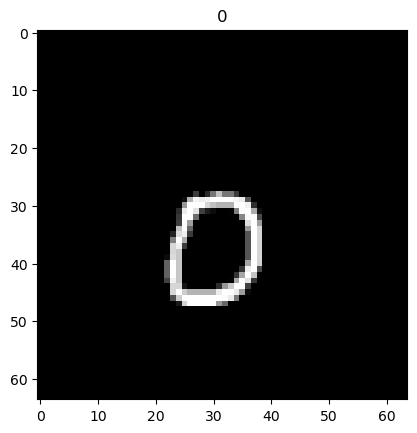

In [40]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

cust_mnist = CustomMNIST(root='./data', train=False, download=True, transform=transform, image_size=64)
# Show an example image
img, target, _, _ = cust_mnist[10]
img = img.permute(1,2,0)
plt.imshow(img, cmap='gray')
plt.title(target)
plt.show()


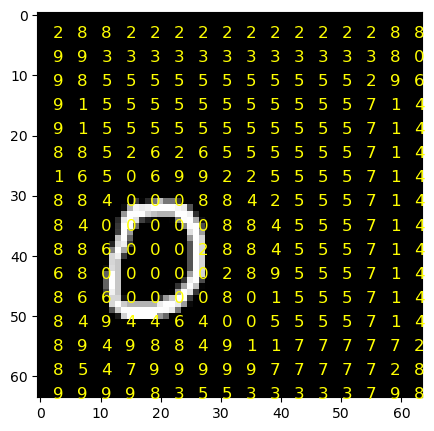

In [35]:
# Show predictions of the FCN Model
img, _, _, _= cust_mnist[10]
img = img.unsqueeze(0).to(device)
output = fcn_model(img)
pred = torch.argmax(output, 1).squeeze()

plt.figure(figsize=(5,5))
plt.imshow(img.cpu().squeeze().numpy(), cmap = 'gray')
for i in range(3, pred.shape[0], 4):
    for j in range(3, pred.shape[1], 4):
        plt.text(j, i, str(pred[i,j].item()),ha='center', va='center', color = 'yellow', fontsize = 12)
plt.show()

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.2 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes.

**Note**: Feel free to implement [Grad-CAM](https://arxiv.org/abs/1610.02391) instead of CAM.

In [1]:
import cv2
import numpy as np
from scipy.ndimage import zoom

class GradCam(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.gradients = None

        self.convs = nn.Sequential(*list(model.children())[:-2])
        self.pooling = model.pooling
        self.fc = model.fc

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.convs(x)
        h = x.register_hook(self.activations_hook)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def get_gradients(self):
        return self.gradients

    def get_activations(self, x):
        return self.convs(x)


def generate_heatmap(model, image, label):
    loss = F.cross_entropy(model(image), label)
    loss.backward()

    grads = model.get_gradients()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(grads, dim=[0, 2, 3])

    # get the activations of the last layer
    activations = model.get_activations(image).detach()

    # weight the channels by corresponding gradients
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # ReLU on the heatmap
    heatmap = F.relu(heatmap)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    return heatmap.detach()

ModuleNotFoundError: No module named 'cv2'

In [91]:
def show_heatmap(image, heatmap):
    # Plot the original image, heatmap and overlayed image
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title('Original Image')
    plt.axis('off')

    # Resize heatmap to the original image size
    heatmap = zoom(heatmap.numpy(), (image.shape[1] / heatmap.shape[0], image.shape[2] / heatmap.shape[1]))
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image.permute(1, 2, 0))
    plt.imshow(heatmap, alpha=0.7)
    plt.title('Overlayed Image')
    plt.axis('off')

    plt.show()

In [67]:
# Load CIFAR10 data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

data = CIFAR10(root='../data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [68]:
convnet = ResNet([2, 2, 2, 2], 10, 3, skip_connection=False)
convnet.load_state_dict(torch.load(os.path.join('./trained_models/', 'cnn_cifar.pth'), map_location=device))

<All keys matched successfully>

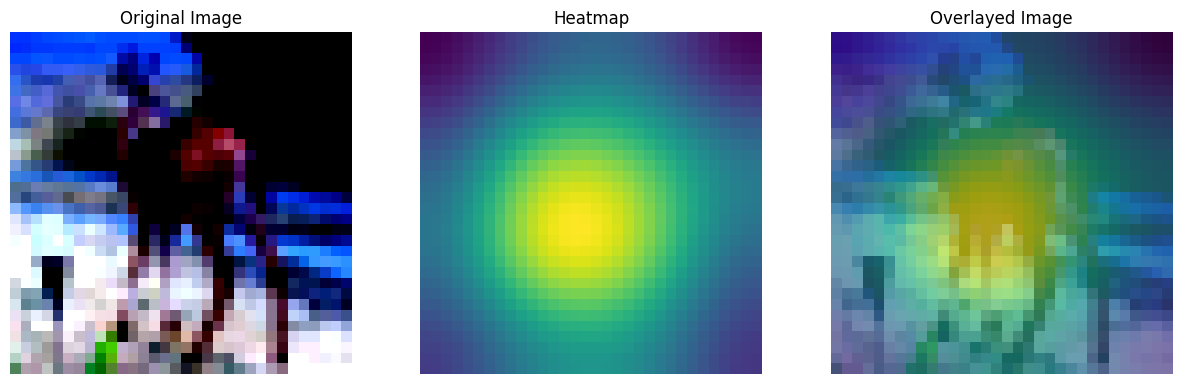

In [92]:
convnet.eval()
gradcam = GradCam(convnet)

# get random image from the test set
xs, ys = data[100]
image = xs
xs = xs.unsqueeze(0).to(device)
ys = torch.tensor([ys]).to(device)

heatmap = generate_heatmap(gradcam, xs, ys)
show_heatmap(image, heatmap)